This notebook provides code for downloading additional data form MODIS, Landsat and Sentinel-2, using Google Earth Engine Python API. 

Firstly, import libraries and read data provided by the competition.

In [119]:
import os, datetime
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd

from src import read_data, process_data, split_df

In [120]:
data = read_data('data/train_dataset_train_2.csv')
data_test = read_data('data/test_dataset_test_2.csv')

In [122]:
data_ts, data_id = process_data(data)
data_ts_test, data_id_test = process_data(data_test)

In [124]:
data_ts.to_csv('data/train_dataset_base.csv', index=False)
data_ts_test.to_csv('data/test_dataset_base.csv', index=False)

In [185]:
data_cat = pd.concat((data_id, data_id_test), axis=0)

# Preliminaries

Authenticate Google Earth Engine. If you are registered there, it will provide an API key to authenticate this notebook.

In [ ]:
import ee
import eeconvert

In [ ]:
ee.Authenticate()
ee.Initialize()

Now we define the primary funciton that will fetch time series data from Google Earth Engine.

In [ ]:
def get_series(collection, features, band='ndvi', scale=30, drive_folder=None):
    """https://stackoverflow.com/questions/47633088/get-results-in-an-earth-engine-python-script"""
    def GetSeries(feature):
        def NDVIcalc(img):
            return feature.set(
                img.reduceRegion(ee.Reducer.median(), feature.geometry(), scale)
            ).set('date', img.date().format('YYYY-MM-dd'))

        series = collection.map(NDVIcalc)

        lst = series.reduceColumns(
            ee.Reducer.toList(2), ['date', band.upper()]).get('list')
        return feature.set(ee.Dictionary(ee.List(lst).flatten()))

    features_mapped = features.map(GetSeries)
    if drive_folder is None:
        result = features_mapped.getInfo()
        return pd.DataFrame([i['properties'] for i in result['features']])
    else:
        task = ee.batch.Export.table.toDrive(
            features_mapped, folder=drive_folder, fileFormat='csv')
        task.start()

# Donwnloading data

## Landsat-8

First, split data into tiles, corresponding to Landsat scenes. This is done beacause otherwise each API call would be too large and get timed out by the server.

In [ ]:
# grid source: https://mgimond.github.io/ArcGIS_tutorials/Download_landsat.htm
grid = gpd.read_file('data/grid/wrs2.shp')
data_grid = data_id.sjoin(grid[['PATH', 'ROW', 'geometry']], how='left')
gb = data_grid.groupby(['PATH', 'ROW'])
tiles = [gb.get_group(x) for x in gb.groups]

Donwnload time series directly with the funciton defined earlier.

In [ ]:
# loop over tiles to get series df for them from GEE
out_b2 = []
out_b5 = []
out_b6 = []
for tile in tqdm(tiles):
    # convert gpd geometry to ee.FeatureCollection
    features = eeconvert.gdfToFc(tile.to_crs(4326)[['id', 'geometry']])
    # define ee.ImageCollection of desired sattelite
    collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_TOA') \
        .filterBounds(features) \
        .filterDate('2021-04-15', '2021-09-01') \
        .select(['B2', 'B5', 'B6'])
    series_b2 = get_series(collection, features, band='B2', scale=30)
    series_b5 = get_series(collection, features, band='B5', scale=30)
    series_b6 = get_series(collection, features, band='B6', scale=30)
    out_b2.append(series_b2)
    out_b5.append(series_b5)
    out_b6.append(series_b6)
# data_landsat = pd.concat(out)

Group results by id and select maximum values in case of duplicates (scene overlapping). We choose max is better bacause in one of the images there can be cluods, so max value (possibly without coluds) is more informative.

In [ ]:
data_landsat = data_landsat.groupby('id').max().reset_index(drop=True)
data_landsat = data_landsat.loc[data_cat['id'], sorted(data_landsat.columns)]

Save the data.

In [ ]:
data_landsat.iloc[:data.shape[0],:].to_csv('data/train_dataset_landsat.csv', index=False)
data_landsat.iloc[data.shape[0]:,:].to_csv('data/test_dataset_landsat.csv', index=False)

## MODIS

First, split data into tiles, corresponding to MODIS scenes.

In [ ]:
# grid source: https://mgimond.github.io/ArcGIS_tutorials/Download_landsat.htm
grid = gpd.read_file('data/grid/modis_sinusoidal_grid_world.shp')
data_grid = data_id.to_crs(grid.crs).sjoin(grid[['h', 'v', 'geometry']], how='left')
gb = data_grid.groupby(['h', 'v'])
tiles = [gb.get_group(x) for x in gb.groups]

Donwnload the data.

In [ ]:
# split tiles further into even smaller dataframes of size <= 100
tiles_gen = (t for tile in tiles for t in split_df(tile, 100))

# loop over tiles to get series df for them from GEE
out = []
for tile in tqdm(tiles_gen):
    # convert gpd geometry to ee.FeatureCollection
    features = eeconvert.gdfToFc(tile.to_crs(4326)[['id', 'geometry']])
    # define ee.ImageCollection of desired sattelite
    collection = ee.ImageCollection('MODIS/MOD09GA_006_NDVI') \
        .filterBounds(features) \
        .filterDate('2021-04-15', '2021-09-01') \
        .select('NDVI')
    series = get_series(collection, features, scale=250)
    out.append(series)
data_modis = pd.concat(out)

Get rid of duplicates and sort date columns.

In [ ]:
data_modis = data_modis.groupby('id').max().reset_index(drop=True).fillna(0)
data_modis = data_modis.loc[data_cat['id'], sorted(data_modis.columns)]

Save the data to local folder.

In [ ]:
data_modis.iloc[:data.shape[0],:].to_csv('data/train_dataset_modis.csv', index=False)
data_modis.iloc[data.shape[0]:,:].to_csv('data/test_dataset_modis.csv', index=False)

## Sentinel-2

In [ ]:
def set_sentinel_ndvi(image):
    red = image.select('B4')
    nir = image.select('B8')
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    return image.addBands(ndvi)

def set_sentinel_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', 
        {'NIR': image.select('B8').divide(10000),
         'RED': image.select('B4').divide(10000),
         'BLUE': image.select('B2').divide(10000)}
    ).rename('EVI')
    return image.addBands(evi)

First, split data into tiles, corresponding to Sentinel-2 scenes. This is done beacause otherwise each API call would be too large and get timed out by the server.

In [ ]:
# grid source: https://github.com/justinelliotmeyers/Sentinel-2-Shapefile-Index
grid = gpd.read_file('data/grid/sentinel_2_index_shapefile.shp')
data_grid = data_id.to_crs(grid.crs).sjoin(grid[['Name', 'geometry']], how='left')
gb = data_grid.groupby('Name')
tiles = [gb.get_group(x) for x in gb.groups]

For Sentinel-2, save results into Google Drive instead of downloading them directly.
Because Sentinel data is too ehavy, direct download would stall out.

In [ ]:
# split tiles further into even smaller dataframes of size <= 100
tiles_gen = (t for tile in tiles for t in split_df(tile, 100))

# loop over tiles to get series df for them from GEE
for tile in tqdm(tiles_gen):
    # convert gpd geometry to ee.FeatureCollection
    features = eeconvert.gdfToFc(tile.to_crs(4326)[['id', 'geometry']])
    # define ee.ImageCollection of desired sattelite
    collection = ee.ImageCollection('COPERNICUS/S2') \
        .map(set_sentinel_ndvi) \
        .filterBounds(features) \
        .filterDate('2021-04-15', '2021-09-01') \
        .select('NDVI')
    # save results into Google Drive
    get_series(collection, features, scale=10, drive_folder='sentinel')

Processing and donwnloading to Google Drive can be monitored here:
https://code.earthengine.google.com/tasks

After the process is finished, download the folder from Google Drive manually. 

In [ ]:
dir_path = 'sentinel'
out = []
for file_name in os.listdir(dir_path):
    out.append(pd.read_csv(dir_path+'/'+file_name))
data_sentinel = pd.concat(out)

Sentinel satellite passes through our regin in midnight, thus producing data with different dates.
Fix this by mapping everything to the date before midnight.

In [ ]:
data_prev = data_sentinel.iloc[:,1:56]
data_prev.columns = pd.to_datetime(data_prev.columns)
data_next = data_sentinel.iloc[:,59:]
data_next.columns = pd.to_datetime(data_next.columns) - pd.Timedelta(days=1)
data_prev.update(data_next)
data_prev['id'] = data_sentinel['id']

Group results by id and select maximum values in case of duplicates (scene overlapping).
We choose max is better bacause in one of the images there can be cluods, so max value (possibly without coluds) is more informative.

In [ ]:
data_sentinel = data_prev.groupby('id').max().reset_index(drop=True).fillna(0)
data_sentinel = data_sentinel.loc[data_cat['id'], sorted(data_sentinel.columns)]

Finally, save the data.

In [ ]:
data_sentinel.iloc[:data.shape[0],:].to_csv('data/train_dataset_sentinel.csv', index=False)
data_sentinel.iloc[data.shape[0]:,:].to_csv('data/test_dataset_sentinel.csv', index=False)

# Eleveation

In [ ]:
import requests
import json

def get_alt(query):
    url = f'https://api.opentopodata.org/v1/srtm30m?locations={query}'
    response = requests.request('GET', url, headers={}, data={})
    return [r['elevation'] for r in json.loads(response.text)['results']]

In [ ]:
latlon = data_cat[['lat', 'lon']].astype(str).apply(','.join, axis=1)
out = []
for batch in tqdm(split_df(latlon, 100)[]):
    query = '|'.join(batch.tolist())
    response = get_alt(query)
    out.extend(response)
data_cat['alt'] = out

In [138]:
data_cat.loc[~data_cat['crop'].isna()].to_file('data/train_dataset_id.geojson', driver='GeoJSON')
data_cat.loc[data_cat['crop'].isna()].to_file('data/test_dataset_id.geojson', driver='GeoJSON')

# Soil

In [225]:
data_id = gpd.read_file('data/train_dataset_id.geojson')
data_id_test = gpd.read_file('data/test_dataset_id.geojson')

In [226]:
data_cat = pd.concat((data_id, data_id_test), axis=0)

In [165]:
soil = gpd.read_file('gsoc17_pictures/mineral.shp')

<AxesSubplot:>

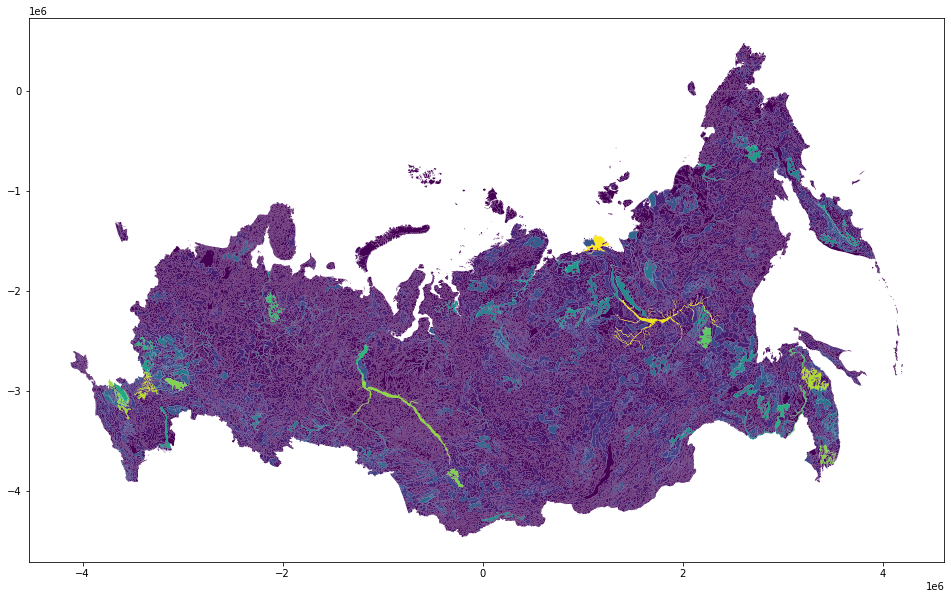

In [168]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
soil.to_crs(3576).plot('Soc_sum_mi', ax=plt.gca())

In [227]:
data_cat_soil = data_cat.sjoin(soil[['Soc_sum_mi', 'geometry']], how='left')

In [228]:
data_cat['soil_carbon'] = data_cat_soil.groupby('id').mean('Soc_sum_mi')['Soc_sum_mi']/1e10

In [229]:
data_cat.groupby('crop').mean()['soil_carbon']

crop
0.0    3.082453
1.0    2.940569
2.0    3.098590
3.0    3.312554
4.0    3.253670
5.0    3.149528
6.0    2.938772
Name: soil_carbon, dtype: float64

<AxesSubplot:xlabel='crop', ylabel='soil_carbon'>

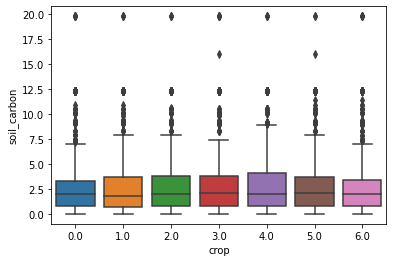

In [230]:
import seaborn as sns
sns.boxplot(data=data_cat.dropna(), x='crop', y='soil_carbon')

In [234]:
data_cat.loc[~data_cat['crop'].isna()].to_file('data/train_dataset_id.geojson', driver='GeoJSON')
data_cat.loc[data_cat['crop'].isna()].to_file('data/test_dataset_id.geojson', driver='GeoJSON')